# **Characterizing the SERT C-terminus structural models**

My research project involves refining ensembles of serotonin transporter (SERT) termini structural models using biophysical data. These generated structural models are very diverse and can be often difficult to study them in terms of **ensembles** compared to the MD simulations. This notebook will highlight some of the most common approaches (dimensionality reduction & clustering) that can taken to study ensembles. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mdtraj as md
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pathlib import Path

In [2]:
# Matplotlib settings for plotting
plt.rc('lines', linewidth=3, markersize=4)
plt.rc('axes', labelweight='heavy', labelsize=22, titlesize=22) # Default fontsizes for printing
plt.rc('axes.spines', top=False, right=False) # Switch off top/right axes
plt.rc('legend', fontsize=16) # Default fontsizes for printing
plt.rc('xtick', labelsize=16) # Default fontsizes for printing
plt.rc('ytick', labelsize=16) # Default fontsizes for printing
plt.rc('figure', titlesize=22, titleweight='heavy') # Default fontsizes for printing

The original data set I use for my research project contains 200,000 SERT C-terminus structural models, which is around 1.2 Gb. I'm  reducing this size by creating a sample data set with subset number of structural models.

In [3]:
# Path to the original 200k structural models and topology
p = Path.cwd()
models = p.parents[1] / 'SERT_termini' / 'cter' / 'structural_models'/ 'cter_200k.trr'
top = p.parents[1] / 'SERT_termini' / 'cter' / 'structural_models' / 'cter_top.pdb'

In [4]:
# Load every 20th structural models to make a new trajectory containing around 10k structural models 
subset_models = md.load(str(models), top=str(top), stride=20)

In [5]:
print(subset_models)

<mdtraj.Trajectory with 9998 frames, 488 atoms, 31 residues, without unitcells>


The new trajectory contains around 10k structural models. I'll save this so the further analyses can be used without the original data.

In [6]:
# Save the new trajectory with 10k structural models
dataname = p.parent / 'data' / 'cter_10k.trr'
subset_models.save(str(dataname))

Perform PCA transformation using two principal components

In [7]:
pca = PCA(n_components=2)
subset_models_pca = pca.fit_transform(subset_models.xyz.reshape(subset_models.n_frames, subset_models.n_atoms * 3))

Create a DataFrame with principal components

In [8]:
df = pd.DataFrame()
df['PC1'] = subset_models_pca[:, 0]
df['PC2'] = subset_models_pca[:, 1]

The first 5 rows can be seen below:

In [9]:
df.head()

,PC1,PC2
0,-6.685674,11.156650
1,-7.374202,5.234386
2,-9.072925,0.640819
3,-7.598984,17.302996
4,-5.650227,-0.299908


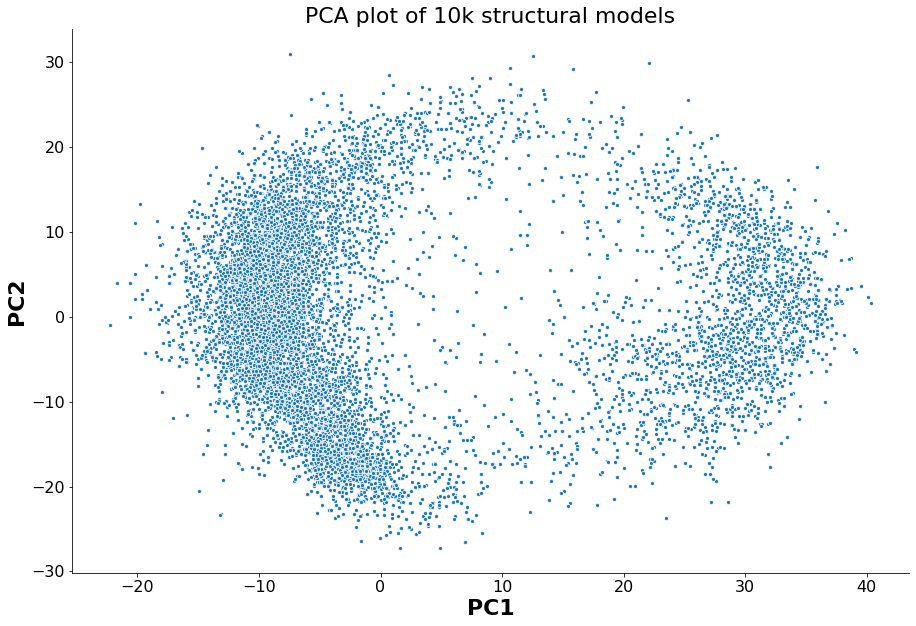

In [10]:
plt.figure(figsize=(15, 10))

sns.scatterplot(df['PC1'], df['PC2'])

plt.xlabel('PC1')
plt.ylabel('PC2')

plt.title('PCA plot of 10k structural models');

Calculate pairwise RMSD that will be used for clustering

In [11]:
distances = np.empty((subset_models.n_frames, subset_models.n_frames))
for i in range(subset_models.n_frames):
    distances[i] = md.rmsd(subset_models, subset_models, i)
print('Max pairwise rmsd: %f nm' % np.max(distances))

Max pairwise rmsd: 1.205989 nm


In [12]:
kmeans = KMeans(n_clusters=2, n_init=100)
clusters = kmeans.fit_predict(subset_models.xyz.reshape(subset_models.n_frames, subset_models.n_atoms * 3))     

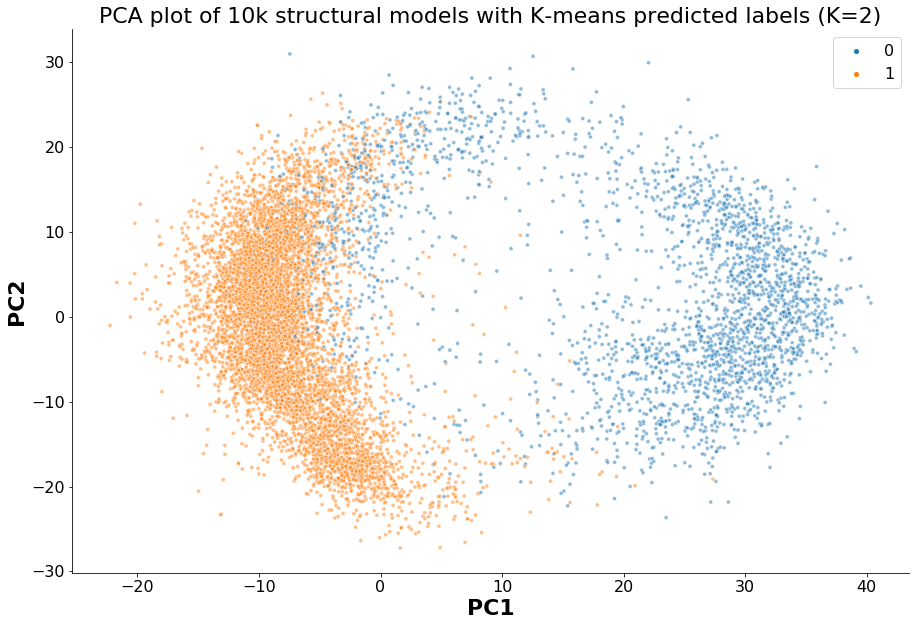

In [13]:
plt.figure(figsize=(15, 10))

sns.scatterplot(df['PC1'], df['PC2'], hue=clusters, alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')

plt.title('PCA plot of 10k structural models with K-means predicted labels (K=2)');

Make a new column with rounded PC1

In [14]:
df['PC1_rounded'] = np.round(df['PC1'])
df['weight'] = 1

In [15]:
pc1 = df.groupby('PC1_rounded')['weight'].sum()

Text(0, 0.5, 'Number of Frames')

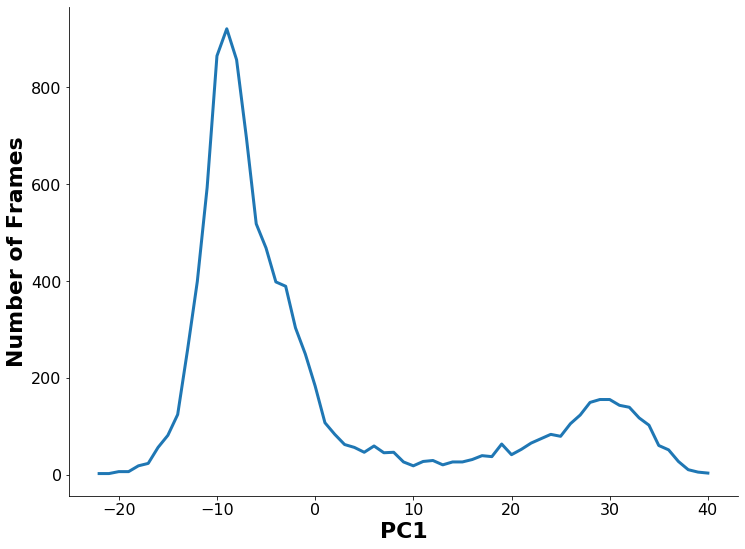

In [16]:
plt.figure(figsize=(12, 9))

plt.plot(pc1.index, pc1.values)

plt.xlabel('PC1')
plt.ylabel('Number of Frames')

In [31]:
# PC1 value smaller than 9.5
df_filter1 = df[df['PC1'] < -9]
df_filter1 = df_filter[df_filter['PC1'] > -10]

In [33]:
df_filter1.head()

,PC1,PC2,PC1_rounded,weight
2,-9.072925,0.640819,-9.0,1
36,-9.377573,-7.218742,-9.0,1
37,-9.437800,-8.822060,-9.0,1
49,-9.806408,6.638382,-10.0,1
58,-9.865905,-5.449108,-10.0,1


In [35]:
# PC1 value smaller than 28.5
df_filter2 = df[df['PC1'] < 29.5]
df_filter2 = df_filter2[df_filter2['PC1'] > 28.5]

In [37]:
df_filter2.head()

,PC1,PC2,PC1_rounded,weight
50,28.530746,-3.252642,29.0,1
105,29.000755,2.578722,29.0,1
261,29.466578,-6.673591,29.0,1
383,29.144123,2.146896,29.0,1
444,28.894077,-10.369122,29.0,1
